# Predicting Lego Set Prices
As new lego sets approach release, there are rumors and leaks, sometimes containing all of the details of the set.
The objective of this model is to be able to predict as accurately as possible, from the available information what hte price of these sets is going to be.

In [1]:
#Imports
import numpy as np
import pandas as pd
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn import preprocessing
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
import category_encoders as ce
from category_encoders import BinaryEncoder
print('imported')

imported


Here we import the data generated from the LegoEDA project. and split our training and validation dataframes into feature and targets.

In [3]:
#read in clean data
lego_train_df = pd.read_csv('../LegoSet_EDA_DataClean/legoData_train.csv')
lego_val_df = pd.read_csv('../LegoSet_EDA_DataClean/legoData_val.csv')


y = lego_train_df.Price
X = lego_train_df.drop(['Price'], axis=1)


y_val = lego_val_df.Price
X_val = lego_val_df.drop(['Price'], axis=1)





## Define model function
Here I define a function that reads in the preprocessor and the data itself.
It then does a cross validation to output the desired scoring parameters.
I am going to look at three parameters, the r2, mean squared error (MSE) and mean absolute error (MAE).
MSE will be the main gauge of how the model improves. 
MAE is just included as it is in the same scale as the input data and is more intuitive to look at.

In [36]:
def linear_model(preprocessor,X,y):    


    my_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('model', LinearRegression(fit_intercept=True))
                             ])
    
    scoring = ['r2','neg_root_mean_squared_error']
    scores = cross_validate(my_pipeline, X, y,
                              cv=5,
                              scoring=scoring,
                              return_train_score=True)

#    print("mean r2: train = "+str(scores['train_r2'].mean())+", test = "+str(scores['test_r2'].mean()))
#    print("mean RMSE: train = "+str(-1*scores['train_neg_root_mean_squared_error'].mean())+", test = "+str(-1*scores['test_neg_root_mean_squared_error'].mean()))
   
    return -1*scores['test_neg_root_mean_squared_error'].mean()

## Preprocessing
### Numerical Data
I want to scall all of my variables to between 0 and 1, I first do this for only pieces, as this is the most correlated feature with price, to get a baseline of measurements for my model.

In [17]:
scaler  = preprocessing.StandardScaler()
preprocessor = ColumnTransformer(
    transformers=[
        ('num', scaler, ['Pieces',]),
    ],
    remainder = 'drop'
)

linear_model(preprocessor,X,y)  


mean RMSE: train = 30.0637645122386, test = 29.931902252278626


29.931902252278626

Next I add in minifigs

In [18]:
scaler  = preprocessing.StandardScaler()
preprocessor = ColumnTransformer(
    transformers=[
        ('num', scaler, ['Pieces','Minifigs']),
    ],
    remainder = 'drop'
)
linear_model(preprocessor,X,y)  

mean RMSE: train = 29.30346792607906, test = 29.179325437072386


29.179325437072386

We can see the RMSE drops significantly.

The next step is to add in release year.

In [19]:
scaler  = preprocessing.StandardScaler()
preprocessor = ColumnTransformer(
    transformers=[
        ('num', scaler, ['Pieces','Minifigs','Year_released']),
    ],
    remainder = 'drop'
)

linear_model(preprocessor,X,y)  

mean RMSE: train = 29.273508173371813, test = 29.15197159003869


29.15197159003869

Adding polynomials to see if they improve the model

In [25]:
scaler  = preprocessing.StandardScaler()
polyn = preprocessing.PolynomialFeatures(4) 

numerical_transformer = Pipeline(steps=[
    ('scale', scaler),
    ('poly', polyn)
])



preprocessor = ColumnTransformer(
    transformers=[('num', numerical_transformer, ['Pieces','Minifigs','Year_released']),
        
    ],
    remainder = 'drop'
)

linear_model(preprocessor,X,y)  



mean RMSE: train = 26.316617511878245, test = 28.334435179188347


28.334435179188347

Adding polynomials definitely improves the model. Adding 4th order polynomials reduces the test RMSE the most, however it also drastically reduces the train RMSE, this could be a sign over overfitting, and may be worth checking again at the end. For now I'll leave it at 4th order.

I am going to graph the RMSE of the data vs cutout year below. (I exclude the last ten years as this would remove too much data from the pool)

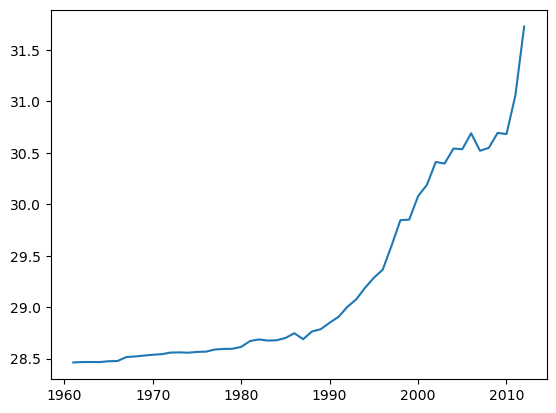

In [37]:
year_list = []
MSE_list = []
for year in range(int(lego_train_df.Year_released.min()),int(lego_train_df.Year_released.max())-10):
    lego_mod_postdate_df = lego_train_df[lego_train_df.Year_released >= year]
    y_new = lego_mod_postdate_df.Price
    X_new = lego_mod_postdate_df.drop(['Price'], axis=1)


    scaler  = preprocessing.StandardScaler()
    polyn = preprocessing.PolynomialFeatures(2) 

    numerical_transformer = Pipeline(steps=[
        ('scale', scaler),
        ('poly', polyn)
    ])

    preprocessor = ColumnTransformer(
        transformers=[('num', numerical_transformer, ['Pieces','Minifigs','Year_released']),

        ],
    remainder = 'drop'
    )

    year_list.append(year)
    MSE_list.append(linear_model(preprocessor,X_new,y_new))
plt.plot(year_list, MSE_list)

We see that the more data the more accurate the model.

In [28]:
#Last time I'll define the numerical transformer, for now.
scaler  = preprocessing.StandardScaler()
polyn = preprocessing.PolynomialFeatures(4) 
numerical_transformer = Pipeline(steps=[
    ('scale', scaler),
    ('poly', polyn)
])



preprocessor = ColumnTransformer(
    transformers=[('num', numerical_transformer, ['Pieces','Minifigs','Year_released'])
    ],
    remainder = 'drop'
)

linear_model(preprocessor,X,y)  


mean RMSE: train = 26.316617511878245, test = 28.334435179188347


28.334435179188347

In [33]:
#Last time I'll define the numerical transformer, for now.
scaler  = preprocessing.StandardScaler()
polyn = preprocessing.PolynomialFeatures(2) 
numerical_transformer = Pipeline(steps=[
    ('scale', scaler),
    ('poly', polyn)
])

full_numerical_transformer = ('num', numerical_transformer, ['Pieces','Minifigs','Year_released'])

preprocessor = ColumnTransformer(
    transformers=[full_numerical_transformer
    ],
    remainder = 'drop'
)

linear_model(preprocessor,X,y)  

mean RMSE: train = 27.76637228205816, test = 28.462414824082696


28.462414824082696

#### Categorical Data
Next we will look at the categorical data.

Some of these features have many unique variables, whereas some have few, as such I will test to see which are better candidates for onehot, binary and target encoding. Below is a function which tests a given feature's test RMSE and outputs which type of encoding lowers the RMSE

In [34]:
from sklearn.preprocessing import OneHotEncoder
from category_encoders import TargetEncoder
from category_encoders import BinaryEncoder
def cat_tester(feat,full_numerical_transformer,  X, y):
    BI_categorical_transformer = Pipeline(steps=[
        ('Binary', BinaryEncoder(return_df=True))

    ])
    OH_categorical_transformer = Pipeline(steps=[
        ('onehot', OneHotEncoder(handle_unknown='ignore', drop = 'first'))

    ])

    TAR_categorical_transformer = Pipeline(steps=[
        ('Target', TargetEncoder())

    ])
    Encoder_Array = [OH_categorical_transformer, BI_categorical_transformer, TAR_categorical_transformer]
    Encoder_names = ["OneHot","Binary", "Target",]
    lowest =0
    lowest_name =''
    for i, (encoder,encoderName) in enumerate(zip(Encoder_Array,Encoder_names)):

        preprocessor = ColumnTransformer(
            transformers=[
                        full_numerical_transformer,
                      ('test_cat', encoder, [feat]),

            ],
            remainder = 'drop'
    )

        rmse_score = linear_model(preprocessor,X,y)
        if i==0:
            lowest_name =encoderName
            lowest = rmse_score
        elif lowest > rmse_score:
            lowest_name =encoderName
            lowest = rmse_score
#        print(encoderName+": "+ str(rmse_score))
    return lowest_name, lowest


In [38]:
cat_feats = [ 'Set_type', 'Theme', 'Theme_group', 'Subtheme']
for feat in cat_feats:
    encoder  = cat_tester(feat,full_numerical_transformer,X,y)
    print(feat + ': ' +encoder[0] + ' = ' + str(encoder[1]))

Set_type: Target = 28.462660812305604


/usr/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/usr/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/usr/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/usr/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Theme: OneHot = 23.280660481147716
Theme_group: OneHot = 25.578940925025233


/usr/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/usr/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/usr/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/usr/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/usr/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0] during tr

Subtheme: Target = 27.891587769540326


The RMSE for no categorical data was  27.968616471809487
The values that just include the the numerical data and a given categorical feature, for the "best" encoding types are given as:

Set_type: Target = 27.967237473854993
Theme: OneHot = 23.396881822698045
Theme_group: OneHot = 25.030535205849837
Subtheme: Target = 27.425683648526313

This shows that including each of these improves on the RMSE

The below run specifies our new best model (this actually excludes subtheme from the model).

In [39]:
#Best Run
OH_categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore', drop = 'first'))
    
])

TAR_categorical_transformer = Pipeline(steps=[
    ('Target', ce.TargetEncoder())
    
])
BI_categorical_transformer = Pipeline(steps=[
    ('Binary', BinaryEncoder(return_df=True))
    
])


preprocessor = ColumnTransformer(
    transformers=[('num', numerical_transformer, ['Pieces','Minifigs','Year_released']),
       #           ('BI_cat', BI_categorical_transformer, ['Set_type']),
                  ('TAR_cat', TAR_categorical_transformer, ['Subtheme','Set_type']),
                  ('OH_cat', OH_categorical_transformer, ['Theme_group', 'Theme'])
    ],
    remainder = 'drop'
)

linear_model(preprocessor,X,y)  

/usr/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/usr/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/usr/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/usr/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


22.96259118413002

Now let's run a prediction on the validation set, training on the full trianing data

In [40]:
my_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('model', LinearRegression(fit_intercept=True))
                             ])
my_pipeline.fit(X, y)
y_preds = my_pipeline.predict(X_val)
np.sqrt(mean_squared_error(y_val, y_preds))

/usr/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


19.598858976246976

19.598858976246976 Not a bad result, in my next project I will look at comparing various models.